In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
!pip install catboost
from catboost import CatBoostClassifier
# !pip install lightgbm
from lightgbm import LGBMClassifier
# !pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 66.1MB 51kB/s 


In [4]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [5]:
import re


def clean(x):
  x = re.sub(r'@\w+'," ",x)
  x = re.sub(r'[^a-zA-Z]'," ",x)
  x = re.sub(r' [a-zA-Z]{1} '," ",x)
  return x

merge = pd.concat([train,test]).reset_index(drop=True)
merge["description_word_len"] = merge.apply(lambda x:len(re.findall(r"\w+",x['Text'])),axis=1)

# merge["Product_Description"] = merge.apply(lambda x:clean(x['Product_Description']),axis=1)

merge

,Labels,Text,Text_Tag,description_word_len
0,1.0,Says the Annies List political group supports ...,abortion,12
1,2.0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",24
2,3.0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,19
3,1.0,Health care reform legislation is likely to ma...,health-care,12
4,2.0,The economic turnaround started at the end of ...,"economy,jobs",10
...,...,...,...,...
11502,NaN,Says his budget provides the highest state fun...,education,13
11503,NaN,Ive been here almost every day.,"civil-rights,crime,criminal-justice",6
11504,NaN,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",21
11505,NaN,Says an EPA permit languished under Strickland...,"environment,government-efficiency",18


In [6]:
!pip install transformers
!pip install -U sentence-transformers

     |████████████████████████████████| 890kB 4.7MB/s 
     |████████████████████████████████| 1.1MB 14.0MB/s 
     |████████████████████████████████| 890kB 42.9MB/s 
     |████████████████████████████████| 3.0MB 44.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4650f38a49c707b6ecbfeab87b37d713f54d072cc49f8ae4157ba3cf0925656a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.6-cp36-none-any.whl size=101182 sha256=78950c31b68832e9e0a736dceb395c00e17e44fdc7a06aeaf8619a4a27e47a2a
  Stored in directory: /root/.cache/pip/wheels/6f/3f/75/c0c4b3ef5dfbf8806d37b8dc661861772aba2f7aa419c85a9b
Successfully built sentence-transformers


In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import tokenizers
print('TF version',tf.__version__)

TF version 2.3.0


In [8]:
from sentence_transformers import SentenceTransformer
sentence_embedder = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

100%|██████████| 459M/459M [00:23<00:00, 19.3MB/s]


In [9]:
%%time
sentence_embeddings = sentence_embedder.encode(merge.Text.values.tolist(),batch_size=64,show_progress_bar=True)


CPU times: user 17.7 s, sys: 8.48 s, total: 26.1 s
Wall time: 32.2 s


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

In [11]:
data = pd.DataFrame(sentence_embeddings)
for i in ["Labels","description_word_len"]:
  data[i] = merge[i].values
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Labels,description_word_len
0,0.063560,0.073301,-0.032392,1.328561,-0.049966,0.453856,0.628987,0.656944,0.336365,-0.718980,-0.523065,0.117198,0.392325,-1.707532,1.734924,-0.535140,-0.777454,-0.276170,1.603683,-0.048415,0.187767,1.092508,-0.965818,0.370986,0.049251,-0.212722,0.347144,0.592574,0.818222,-0.622406,-0.066764,-0.709957,1.011619,0.799267,-1.426885,0.750666,0.408302,-0.205323,-0.355312,0.131708,...,0.245669,-0.028860,-0.228528,0.709462,-0.109206,-0.864664,-0.571643,0.271224,0.140375,0.527754,0.293081,0.707496,-0.121856,-0.238606,-0.167470,0.532090,-0.784435,0.310021,0.855216,-1.080695,-0.435191,0.999487,0.616212,-0.687343,-0.290360,0.888546,0.124928,-0.328209,0.707740,0.125505,0.349460,-0.382211,1.345452,0.671240,-0.090032,-0.924622,0.593463,-0.151931,1.0,12
1,-0.251281,-0.427434,-0.002071,-1.095850,-0.286984,-0.405637,0.545491,-0.388818,0.524717,0.264293,-0.221856,-0.767040,0.560676,0.412191,0.701180,-1.076047,0.152843,-0.465250,1.059205,-0.793980,0.130142,-0.766056,-1.310127,0.302492,0.664665,0.268464,-0.820143,-0.223503,-0.376286,0.804399,0.264717,-1.643689,-0.089634,0.300050,0.555269,0.804935,0.344442,-0.669683,-0.397973,-0.163724,...,-0.088812,-0.091500,-0.292945,-0.901554,-0.558430,-0.831444,-0.358893,-0.757866,-0.254299,1.096235,0.742879,-1.358797,0.432696,-0.645251,0.059540,-0.145762,0.658848,0.287486,-1.507575,1.387248,0.655001,0.358216,-0.566804,-0.562429,-0.590608,-0.681181,-0.153860,-0.055659,0.449812,-1.002035,-0.211105,0.256450,-0.323354,0.298147,0.432781,-1.182147,0.014274,-0.618579,2.0,24
2,0.573639,0.121655,-0.146541,0.829189,-0.009897,-0.721361,0.463739,0.480718,1.374565,-0.134240,0.213348,1.277718,0.035343,0.015560,0.990550,-1.094034,-1.145655,-0.225677,0.881350,1.428741,0.080706,-0.124760,-0.501451,-0.439607,0.803869,-0.899981,-0.029620,0.512224,-0.708447,-0.790173,-0.769995,0.109231,-0.286182,-0.759383,0.874900,0.431463,0.519089,-1.490189,1.714779,-0.302448,...,-0.400202,-0.336939,0.226240,1.056105,-0.104023,0.050857,-0.347701,-0.601614,0.106587,0.668422,0.270226,0.491968,0.338271,0.554601,-0.512805,0.517944,0.442927,-0.606080,-0.321015,1.011613,0.571460,0.429441,-0.571273,-0.563386,0.512104,0.620863,-0.515939,0.116588,-0.635795,-0.543450,-1.251009,0.389167,0.127668,-0.334684,0.480950,0.778090,-0.727586,0.076265,3.0,19
3,1.256146,0.762252,0.183387,-0.102740,0.100233,0.485516,0.039703,-0.064118,-0.129972,-0.187276,-0.590891,0.301299,0.336908,-0.507577,1.184028,0.809107,-1.119787,-0.144035,1.330422,-0.666107,-0.146527,0.277192,-0.147844,0.470080,1.032401,-0.676207,-0.765087,-0.855749,1.284815,1.972796,0.168044,-0.975069,0.850745,0.055221,-2.939077,-0.182672,1.071114,0.063145,-0.407185,0.379258,...,-1.049567,0.852734,-0.448103,-0.907477,-0.754061,-1.467764,-1.582530,-0.216108,0.287742,0.445228,-0.508206,-0.164043,-0.223222,0.498422,-0.625090,-0.397663,-0.816500,0.123005,-0.602281,0.598906,0.575143,-0.134616,-0.706615,0.771364,-0.202929,0.477270,-0.782848,-0.293598,0.355463,-0.488293,0.624700,-0.668802,0.678824,0.429868,0.099315,-1.353076,0.240514,-0.293187,1.0,12
4,-0.105395,0.239276,0.312050,-0.679842,-0.468683,-0.453708,0.445753,-0.465910,0.302358,0.581789,0.223785,-0.457418,-0.223258,0.085531,0.217647,-1.434162,0.737862,-0.644397,1.429508,-0.380319,0.036499,-0.956546,-0.021067,1.130896,1.060700,-0.024587,0.793601,0.736174,-1.181386,0.747694,-0.470220,-1.336181,-0.018791,0.045244,-0.488562,0.403916,0.056206,-0.547934,-1.338844,-0.349687,...,-0.580704,-1.088711,-0.172827,-0.165988,0.098619,-0.285523,0.082112,0.712734,-0.525181,0.583475,0.326674,0.415110,0.073273,-0.469046,0.160240,-0.527098,-0.716552,-0.117144,-0.537304,1.876257,0.348964,0.407179,-1.362732,-0.846133,-0.407397,-0.852433,-1.463688,-0.266734,-0.121205,-0.133458,-0.121810,1.

In [13]:
train = data[~data.Labels.isna()]
test = data[data.Labels.isna()]
test.drop("Labels",axis=1,inplace=True)

0:	learn: 0.2608643	test: 0.2094727	best: 0.2094727 (0)	total: 66.4ms	remaining: 27m 40s
200:	learn: 0.5189209	test: 0.2392578	best: 0.2431641 (26)	total: 6.33s	remaining: 13m 1s
400:	learn: 0.7072754	test: 0.2451172	best: 0.2509766 (378)	total: 12.4s	remaining: 12m 43s
600:	learn: 0.8214111	test: 0.2514648	best: 0.2573242 (551)	total: 18.5s	remaining: 12m 29s
800:	learn: 0.8941650	test: 0.2529297	best: 0.2578125 (754)	total: 24.5s	remaining: 12m 20s
1000:	learn: 0.9406738	test: 0.2539063	best: 0.2578125 (754)	total: 30.5s	remaining: 12m 11s
1200:	learn: 0.9705811	test: 0.2573242	best: 0.2607422 (1095)	total: 36.5s	remaining: 12m 2s
1400:	learn: 0.9846191	test: 0.2539063	best: 0.2607422 (1095)	total: 42.5s	remaining: 11m 55s
bestTest = 0.2607421875
bestIteration = 1095
Shrink model to first 1096 iterations.
1.716776314422067
------------------------------------------------------------------------------------------------------------------------------------------------------
0:	learn: 0.

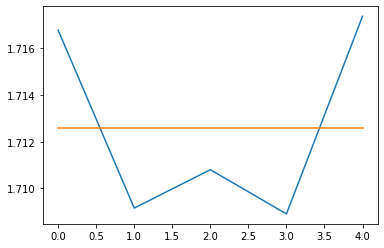

In [14]:
X = train.drop(["Labels"],axis=1)
Y = train[['Labels']]

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0355,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    "boosting_type":"Plain"
}

best_score = np.inf
scores = []

folds_large = KFold(n_splits=5,shuffle=True,random_state=1250)

for train_idx , test_idx in folds_large.split(X,Y):
  train_set = (X.iloc[train_idx],Y.iloc[train_idx])
  test_set = (X.iloc[test_idx],Y.iloc[test_idx])

  model = CatBoostClassifier(**params)
  model.fit(*train_set,
            eval_set=[test_set],early_stopping_rounds=500,verbose=200)

  score = log_loss(test_set[1].values,model.predict_proba(test_set[0]))
  print(score)
  scores.append(score)
  

  if score < best_score:
    best_score = score
    best_model = model

  print("---"*50)

print(f"Mean Score : {np.array(scores).mean()}")
print(f"Min Score : {np.array(scores).min()}")
print(f"Max Score : {np.array(scores).max()}")

plt.plot(scores)
plt.plot(np.arange(len(scores)),[np.array(scores).mean()]*len(scores),)
plt.show()

model_large = best_model

In [15]:
pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_rows",150)
m = pd.DataFrame(list(zip(X.columns,model_large.feature_importances_))).sort_values(1,ascending=False)
m

,0,1
335,335,2.451589
240,240,1.976146
768,description_word_len,1.905794
5,5,1.764115
41,41,1.666419
...,...,...
354,354,0.000000
353,353,0.000000
641,641,0.000000
642,642,0.000000


In [17]:
submission = pd.DataFrame(model_large.predict_proba(test))
submission.columns = [f'Class_{i}' for i in submission.columns]
submission.to_csv("submission_large.csv",index=False)

In [22]:
from sentence_transformers import SentenceTransformer
sentence_embedder = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')



100%|██████████| 1.31G/1.31G [01:01<00:00, 21.2MB/s]


In [23]:
%%time
sentence_embeddings = sentence_embedder.encode(merge.Text.values.tolist(),batch_size=64,show_progress_bar=True)


CPU times: user 47.7 s, sys: 29.6 s, total: 1min 17s
Wall time: 1min 17s


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

In [25]:
data = pd.DataFrame(sentence_embeddings)
for i in ["Labels","description_word_len"]:
  data[i] = merge[i].values
data.head()
train = data[~data.Labels.isna()]
test = data[data.Labels.isna()]
test.drop("Labels",axis=1,inplace=True)

0:	learn: 0.2453613	test: 0.2065430	best: 0.2065430 (0)	total: 42.4ms	remaining: 17m 39s
200:	learn: 0.5466309	test: 0.2412109	best: 0.2480469 (183)	total: 7.68s	remaining: 15m 47s
400:	learn: 0.7188721	test: 0.2402344	best: 0.2480469 (183)	total: 15.1s	remaining: 15m 26s
600:	learn: 0.8352051	test: 0.2524414	best: 0.2563477 (542)	total: 22.5s	remaining: 15m 11s
800:	learn: 0.9031982	test: 0.2578125	best: 0.2592773 (632)	total: 29.8s	remaining: 14m 59s
1000:	learn: 0.9440918	test: 0.2543945	best: 0.2656250 (879)	total: 37s	remaining: 14m 47s
1200:	learn: 0.9711914	test: 0.2460938	best: 0.2656250 (879)	total: 44.3s	remaining: 14m 37s
bestTest = 0.265625
bestIteration = 879
Shrink model to first 880 iterations.
1.7077830830501015
------------------------------------------------------------------------------------------------------------------------------------------------------
0:	learn: 0.2540283	test: 0.2075195	best: 0.2075195 (0)	total: 42.2ms	remaining: 17m 34s
200:	learn: 0.5567627	

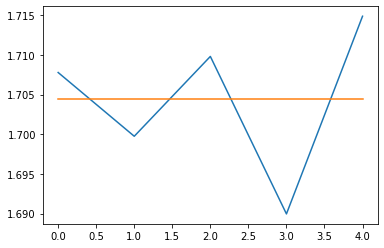

In [26]:
X = train.drop(["Labels"],axis=1)
Y = train[['Labels']]

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0355,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    "boosting_type":"Plain"
}

best_score = np.inf
scores = []

folds_large = KFold(n_splits=5,shuffle=True,random_state=1250)

for train_idx , test_idx in folds_large.split(X,Y):
  train_set = (X.iloc[train_idx],Y.iloc[train_idx])
  test_set = (X.iloc[test_idx],Y.iloc[test_idx])

  model = CatBoostClassifier(**params)
  model.fit(*train_set,
            eval_set=[test_set],early_stopping_rounds=500,verbose=200)

  score = log_loss(test_set[1].values,model.predict_proba(test_set[0]))
  print(score)
  scores.append(score)
  

  if score < best_score:
    best_score = score
    best_model = model

  print("---"*50)

print(f"Mean Score : {np.array(scores).mean()}")
print(f"Min Score : {np.array(scores).min()}")
print(f"Max Score : {np.array(scores).max()}")

plt.plot(scores)
plt.plot(np.arange(len(scores)),[np.array(scores).mean()]*len(scores),)
plt.show()

model_large = best_model

In [27]:
pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_rows",150)
m = pd.DataFrame(list(zip(X.columns,model_large.feature_importances_))).sort_values(1,ascending=False)
m


submission = pd.DataFrame(model_large.predict_proba(test))
submission.columns = [f'Class_{i}' for i in submission.columns]
submission.to_csv("submission_2.csv",index=False)

In [31]:
sub1 = pd.read_csv('submission.csv')
sub2 = pd.read_csv('submission_2.csv')
sub3 = pd.read_csv('submission_large.csv')
sub1.head()

,0,1,2,3,4,5
0,0.147928,0.182078,0.218269,0.224169,0.066129,0.161427
1,0.158105,0.210149,0.272833,0.148255,0.057894,0.152765
2,0.154479,0.234471,0.127751,0.107683,0.199263,0.176353
3,0.284520,0.248342,0.223991,0.095079,0.072980,0.075088
4,0.224200,0.221353,0.185514,0.152297,0.091304,0.125333


In [32]:
sub2.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
0,0.144328,0.187056,0.214548,0.220515,0.047799,0.185755
1,0.154987,0.226658,0.227379,0.220604,0.051704,0.118669
2,0.183593,0.208217,0.183206,0.167455,0.111110,0.146420
3,0.246251,0.232915,0.173673,0.121885,0.138487,0.086789
4,0.120018,0.248150,0.176897,0.144238,0.130407,0.180289


In [33]:
sub3.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
0,0.144155,0.159741,0.218994,0.232749,0.061525,0.182836
1,0.176976,0.189439,0.229539,0.196542,0.057070,0.150434
2,0.160648,0.257159,0.159403,0.137428,0.136295,0.149067
3,0.226314,0.236189,0.200409,0.134851,0.098355,0.103881
4,0.181556,0.258080,0.181930,0.151954,0.089014,0.137467


In [36]:
final = (sub2 + sub3)/2
final.to_csv('final.csv',index=False)
final

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
0,0.144242,0.173399,0.216771,0.226632,0.054662,0.184295
1,0.165981,0.208049,0.228459,0.208573,0.054387,0.134551
2,0.172121,0.232688,0.171304,0.152441,0.123703,0.147743
3,0.236282,0.234552,0.187041,0.128368,0.118421,0.095335
4,0.150787,0.253115,0.179414,0.148096,0.109711,0.158878
...,...,...,...,...,...,...
1262,0.103055,0.174649,0.260526,0.258587,0.041670,0.161513
1263,0.136583,0.192200,0.152044,0.210918,0.054878,0.253378
1264,0.209828,0.199270,0.197251,0.135749,0.123084,0.134818
1265,0.171336,0.175172,0.204491,0.203346,0.069467,0.176188
